# Feedback from previous weeks and other and hints

1. Be careful about your environment remembering variables. Make sure your code works in a new _clean_ environment. In Colab: `Runtime`->`restart Runtime`, in Anaconda's Jupyter: `Kernel`->`Restart`.
2. Keep the file names when saving to GitHub. It's always possible to go back to a previous version, you are not losing anything.
3. Run all the cells before saving to GitHub so the output is saved.
4. Graphs without labels (or units when appropriate) are not worth any point.
5. Do put in sufficient explanatory comments in your code.

For this week you can use these imports:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

Read the worksheet carefully before doing the exercises.

# Introduction

In this worksheet we’ll look at the extraction of information from experimental data. This is important for PX2338 (Obs tech) and your work in the year 2 lab as well as your year 3/4 project.

We’ll first examine fitting of data with a straight line and then move on to more complicated functions.

## Fitting with a straight line

Let’s see how to fit data with a straight line, taking advantage of functions. **Go back to week 2 - Functions** and make sure you understand it. In particular, from week2 exercise 3 you fitted a straight line to data. Your code should look something like the code below. You will already have defined a function called linfit, which works along these lines:

slope:  99.0595238095238 +/- 0.9295121405070327
intercept:  6.166666666666632 +/- 3.8884282607017973



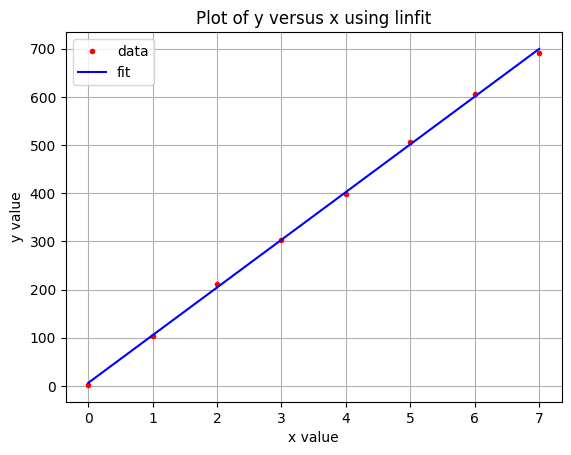

In [4]:
# put some test data into arrays ...
x_data = np.array([ 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0 ])
y_data = np.array([ 2, 104, 212, 302, 398, 507, 606, 692 ])

# define a nice, self-contained fitting routine.
def linfit(x, y):
    '''
    Takes input arrays x an y and performs a linear least squares fit.
    Returns estimated slope, error is slope,
    intercept, error in intercept.
    '''
    # do LSF using method described in PX1224 week 4 ...
    p_coeff, residuals, _, _, _ = np.polyfit(x, y, 1, full=True)
    # Note: residuals is returned as an array with one element.
    # residuals[0] is the value of this element
    n = len(x)
    D = sum(x**2) - 1./n * sum(x)**2
    x_bar = np.mean(x)
    dm_squared = 1./(n-2)*residuals[0]/D
    dc_squared = 1./(n-2)*(D/n + x_bar**2)*residuals[0]/D
    dm = np.sqrt(dm_squared)
    dc = np.sqrt(dc_squared)
    return p_coeff[0], dm, p_coeff[1], dc

# Calling the fitting function:
m, dm, c, dc = linfit(x_data, y_data)
print ('slope: ', m, '+/-', dm)
print ('intercept: ', c, '+/-', dc)
print ()

# Now for plotting purposes, we define a linear function
def linear(x, m, c):
    return m*x + c

# alternative method to define the linear function
# (effectively, it's identical to the other method
# *p means just a list of values)
def linear(x, *p):
    return p[0]*x + p[1]

# plot data
plt.plot(x_data, y_data, 'r.',label='data')
# plot fit
x_plot = np.linspace(min(x_data),max(x_data),num=100)
plt.plot(x_plot, linear(x_plot, m, c), 'b-',label='fit')
plt.xlabel('x value')
plt.ylabel('y value')
plt.title('Plot of y versus x using linfit')
plt.legend()
plt.grid ()

The above thus implements a linear least squares fit using polyfit. **Make sure that your linfit routine works ok**. You can use this whenever you have data in the year 2 lab that you need to fit to a straight line.

## Fitting with a more general function
You can of course easily extend this and fit polynomials using `polyfit`, but what about more complicated functions? We’ll take advantage of the `scipy.optimize` routine `curve_fit` to fit directly just about any function we wish.
The general way the curve fitting function is used is like this

```python
popt, pcov = curve_fit(f=func, xdata=x, ydata=y, p0=init_guess, bounds=([a_min, b_min], [a_max, b_max]))
```

Here, `func` is just the name of a function that you have defined, `x` and `y` are equal length data arrays, `init_guess` is an array of initial values (somewhere near to the final values you expect). (They don’t have to be called func, x, y and init_guess since those names are up to you in your program. But the `f=` parts and so on must be written as above.) The term `bounds` is to constrain the range of the parameters fitted and can usually be left out.

There are other keywords which you can explore in Jupyter notebook’s help (Cmd/Ctrl+Space, Option+Esc or Tab for autocomplete, Cmd/Ctrl+Shift+Space for Docstring, depending on your settings and shortcuts. Cmd for Macs, Ctrl for Windows). Or go to this [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html).

Actually, the above form can be simplified slightly to

```python
# recommended form to use
popt, pcov = curve_fit(func, x, y, init_guess, bounds=([a_min, b_min], [a_max, b_max]))
```

and you may not need the `bounds` key word.

An example to show the usage is below. Here, we define a quadratic function as an illustration and check we get sensible result.

In [ ]:
def quadratic(x, *p):
    return p[0]*x**2 + p[1]*x + p[2]

Do not run `curve_fit()` right away ! First make sure your fitting function makes sense. This is best done by plotting it with some guess parameters against the data:

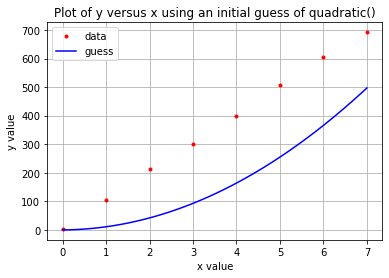

In [ ]:
x_plot = np.linspace(min(x_data),max(x_data),num=100)

# compute a guess curve by creating an array y_guess of data points.
p_guess = np.array([10.0, 1.0, 0.0]) # initial guess
y_guess = quadratic(x_plot, *p_guess) # values come from an educated guess looking at the data.

# plot data
plt.plot(x_data, y_data, 'r.',label='data')
# plot fit
plt.plot(x_plot, y_guess, 'b-',label='guess')
plt.xlabel('x value')
plt.ylabel('y value')
plt.title('Plot of y versus x using an initial guess of quadratic()')
plt.legend()
plt.grid ()

In [ ]:
# now do curve fit. We can use the initial guess from before
# we must pass the #name# of the function ...
popt, pcov = curve_fit(quadratic, x_data, y_data, p_guess) # do fit

A few things to note:
We pass to the `curve_fit` routine the _name_ of the function we are fitting, which in this example is the `quadratic` function defined earlier.
The `x_data` and `y_data` arrays are passed in, as well as an initial guess of the variables (which is not that crucial in this case, **but can be critical in some cases**).
The optimised values are returned in the array `popt`, and information on the goodness of fit is returned in the array `pcov`.
Thus the error in `popt[0]` can be found as `sqrt(pcov.diagonal()[0])` and likewise for the other optimised values.
Once the fit is done, you can use the results - printing out the fitted coefficients and the errors for example, or plotting the data and the fitted curve.

a:  -0.5297619047848805 +/- 0.4506307555014284
b:  102.76785714307914 +/- 3.280641440439505
c:  2.4583333333387096 +/- 4.9158036871993405



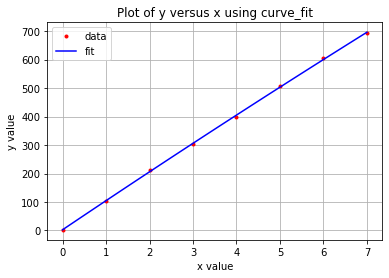

In [ ]:
print ('a: ', popt[0], '+/-', np.sqrt(pcov.diagonal()[0]))
print ('b: ', popt[1], '+/-', np.sqrt(pcov.diagonal()[1]))
print ('c: ', popt[2], '+/-', np.sqrt(pcov.diagonal()[2]))
print ()

x_plot = np.linspace(min(x_data),max(x_data),num=100)

# find fitted curve by creating an array yfit of data points ...
yfit = quadratic(x_plot, *popt)

# plot data
plt.plot(x_data, y_data, 'r.',label='data')
# plot fit
plt.plot(x_plot, yfit, 'b-',label='fit')
plt.xlabel('x value')
plt.ylabel('y value')
plt.title('Plot of y versus x using curve_fit')
plt.legend()
plt.grid ()

Note: the method we’ve used to pass the calculated coefficients to the linear function for plotting `quadratic(x, *popt)` is an alternative to `quadratic(x, popt[0], popt[1], popt[2])` with the same result, but this new notation saves a lot of typing if we have a function of many parameters.

Note2: if there are not many data points it is better (as done in week 2) to set up a new more appropriate array of x values (here called `x_plot`) so that you get a nice smooth curve.

Do the values found for the coefficients make sense to you? What about the errors compared to the errors when using the simpler linear fit?

# Exercises
This must be marked before you leave the lab. Mark weighting is in brackets.
**Save your work to GitHub after having run all cells with `Runtime` -> `Restart and run all`. And do not change the notebook's filename.** Do add comments to your code, you'll lose points if your code is hard to understand. Graphs without labels (or units when appropriate) are not worth any point.

**Note**: "fitting" does include providing the error measurements. E.g. the answer is not $a=100$ but $a=100^+_-1$.

## Exercise 0

[0] See the video on LearningCentral about fitting a Power Law to the Black Holes mass distribution.

## Exercise 1
[2] Use the above ideas to repeat a _linear_ fit using the `curve_fit` routine (not a _quadratic_ as in the example in the introduction). Confirm, by using your linfit function, that you get the same result as before.

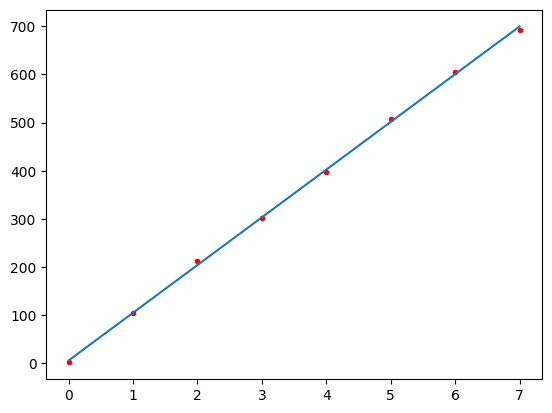

In [9]:
import utilities

def linear(x, *p):
    return p[0]*x + p[1]

x_data=np.array([ 0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0 ])
y_data=np.array([ 2, 104, 212, 302, 398, 507, 606, 692 ])
plt.plot(x_data, y_data, 'r.',label='data')

p_guess=[50,2]

popt, pcov = curve_fit(linear, x_data, y_data, p_guess)

x_plot=np.linspace(min(x_data),max(x_data),num=100)
plt.plot(x_plot,linear(x_plot, *popt))

## Exercise 2
The data file `XRD_data_Mo_anode.csv`:

In [ ]:
! wget -q https://raw.githubusercontent.com/PX2134/data/master/week4/XRD_data_Mo_anode.csv

SSL_INIT


contains X-ray diffraction data from a molybdenum anode source, obtained using a NaCl crystal. It shows two features, the K-alpha and K-beta (in the data one can see 3 orders – the 4th is present but weak) on top of a Brehmstrahlung (braking radiation) background. The columns are angle in degrees and intensity (measured as counts per second).

1) [3] Read in the raw data points and plot a graph. Estimate **by eye** and make a note of the rough positions, widths and intensitys of the **first** two **main** peaks in first order (highest peaks), around angles of 6 and 7 degrees. Create a single data array that include the angle and count values from around those two peaks. For instance, to only have the data between angle of 1 and 30 you could do:

    ```python
    angles_selected=angles_full_data[(angles_full_datat>=1) & (angles_full_data<=30)]
    counts_selected=counts_full_data[(angles_full_datat>=1) & (angles_full_data<=30)]
    ```
    
    (1 and 30 are not the right values, you need to look at the plot, and make surer you include all of both peaks, but minimise any other features such as higher order peaks or drop-offs).

2) [2] The peaks can be approximated as Gaussian in shape, i.e.: $$G(x;I,\mu,\sigma)=I\frac{1}{\sigma\sqrt{2\pi}}\exp \left(-\frac{(x-\mu)^2}{2\sigma^2} \right)$$ Define (in a similar way you did for the linear fitting) a Gaussian function, which you will use for fitting the data:

    ```python
    Gau(x, intensity, mu, sigma)
    ```

    Note that this Gaussian is normalised to have an area under the curve of intensity (I).

3) [2] Now use `curve_fit()` to try fitting a Gaussian to the highest peak in the data you selected containing those first two peaks near 6 and 7. and plot the result. Remember to first plot your guess !

4) [3] Repeat, but allowing for a constant background offset to improve the fit. Hint: Do this by defining a fitting function comprising a constant term plus a Gaussian, say `Gau_background(x, intensity, mu, sigma, bckg)`. (You can call the `Gau()` function from within `Gau_background()`. You now have four fitting parameters instead of three.)  
  
5) [4] Repeat, but allowing for a linear background to improve the fit. (This requires a function with an extra fitting parameter.)

6) [4] Repeat, but allowing not only for a linear background to improve the fit, but also trying to fit the other peak together with the main one.

Notes:

  - Always plot your fitting function with some guesses first.
  - If the error on all the parameters is very large, in general it means `curve_fit()` did not really manage to fit anything, don't use those values.
  - Remember parameters are (by default) unbounded floats, e.g. if you try to fit a Gaussian at ~6.8, `curve_fit()` will hapilly try a negative intensity, e.g. fit a dip instead of a peak.
  - When using bounds, careful with railing ! If the errors or values are equal (or nearly equal) to the bounds, the fit is not reliable and depends on the provided bounds.
  - When fitting both signal and background, you can also try subtracting the background fit to the data.
